<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_dedalus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the diffusion equation with Dedalus

**Overview:** This notebook solves the diffusion equation using a spectral method and provides an introduction to Dedalus.

**About Dedalus:** [Dedalus](http://dedalus-project.org) is an open-source Python package for solving partial differential equations (PDEs) using spectral methods.
These methods provide highly accurate numerical solutions for PDEs with smooth solutions in simple domains like boxes and spheres.
Dedalus implements modern parallel algorithms utilizing sparse polynomial bases, but all with an easy-to-use symbolic interface.
The code is being used in a wide range of fields, often for problems involving fluid dynamics.

This script is based in part on the Introduction to Dedalus by [Keaton Burns](http://keaton-burns.com)

The student exercise starts in [Section 5](#student_investigation)

# 1. Setup

First, we need to install Dedalus.  If you are running Python on your local computer, follow the install instructions in the [Dedalus Docs](https://dedalus-project.readthedocs.io/en/latest/pages/installation.html) to install Dedalus locally on your computer.

The cell below checks to see if Dedalus is installed.  After installing Dedalus, run the cell below to verify that Dedalus is installed correctly.

If you are using Google Colab, the cell below will automatically install Dedalus.

This cell checks if Dedalus is installed and performs some other basic setup. This will take some time the first time you run it.

Once you have Dedalus installed, you won't need to run this cell again.

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://archiv

At the start of each Python script, we need to import the packages that we will use.  The cell below imports the packages that will be needed here, namely numpy, matplotlib (for plotting) and dedalus. Note that we assign aliases for numpy, matplotlib, and dedlaus. Run this cell before running any of the cells below.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

## 2. Dedalus basics

Dedalus solves PDEs using spectral methods.  Dedalus requires us to specify the spatial coordinates, the `distributor`, and the spectral bases, which are explained below.

### Coordinates

We can use a variety of coordinate systems in Dedalus. For example, for multi-dimensional problems, we can use Cartesian coordinates, polar coordinates, spherical coordinates, etc. Here, we will set up a 1D problem using the Dedalus `Coordinate` class. We will see other examples in future projects.
For more details on other problem types, included distributed parallel simulations, see the official [Dedalus Tutorial 1](https://dedalus-project.readthedocs.io/en/latest/notebooks/dedalus_tutorial_1.html).

Let's create a coordinate object representing our 1D coordinate, which here we will call `x`:

In [4]:
xcoord = dedalus.Coordinate('x')

### Distributors

Dedalus uses MPI (Message Passing Interface) for allow parallel computation on distributed memory systems. There are various options for how to distribute the computation amongst the processes. In Dedalus this is done by an object called a `Distributor`. Here, we will run not run in paralle, but Dedalus still requies us to create a `Distributor` object. You don't need to worry about this now, we will discuss it further in later projects.

The line below creates a distributor for our x coordinate for a problem with real variables.

In [5]:
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization

### Spectral basis

Dedalus decomposes the PDE that we are solving using a spectral basis. Dedalus has the ability to use different basis functions for this decomposition, and this gives Dedalus remarkable flexibility. For example, `RealFourier` provides a Fouier basis (sine and cosine functions) can be used for problems that are periodic (cyclic) in physical space. The `Chebyshev` basis allows boundary conditions to be set on a finite interval. The `SphereBasis` allows us to solve problems on a sphere.

The line below creates a Fourier basis for a real-valued system with a domain size of Lx=10 and with Nx=1024 gridpoints in physical space.

In [6]:
# Set some parameters
Nx = 1024 # The number of gridpoints. Note that Fourier transforms are more efficient if this is a power of 2
x_start=-1; x_end=1 # The starting and ending bounds on x

# Construct a Fourier basis
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))

### Grids

Each basis has a corresponding grid in physical space that can be used for tasks like initializing and plotting fields.

The line below creates a grid for the x coordinate.


In [7]:
x = dist.local_grid(x_basis)

### Fields

`Field` objects in Dedalus represent scalar-valued fields defined over a set of bases (or a "domain").
For multidimensional problems, vector and tensor valued fields can also be constructed using the `VectorField` and `TensorField` clases.

Let's construct a field called `c` (for concentration) using our 1D basis:

In [8]:
c = dist.Field(name='c', bases=x_basis)

Field objects have internal methods for transforming their data between grid (`'g'`) and coefficeint (`'c'`) space representations.
The field's values can be assigned and retrieved by indexing a field with these strings.

Let's set the grid-space values of our field, `c`, to be a Gaussian function of `x`. This is how we set the initial condition for the initial value problem that we will solve below.

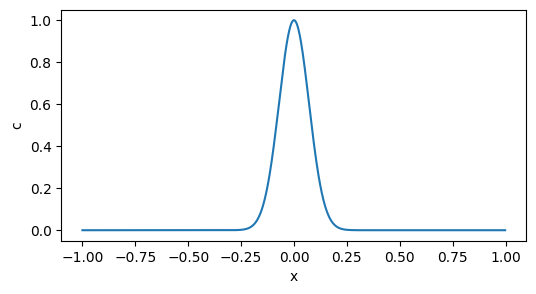

In [9]:
w = 0.1 # Set the width of the initial Gaussian
c.change_scales(1) # Set values on regular grid
c['g'] = np.exp(-x**2/w**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)

plt.figure(figsize=(6, 3)) # Set the size of the figure
plt.plot(x, c['g']) # Plot the "grid-space" initial conditions
plt.xlabel('x'); plt.ylabel("c"); # Set the axis labels

As a bit of an aside, we can find the coefficients of the spectral representation of a field using ['c'] instead of ['g'].
This triggers an in-place spectral (in this case Fourier) transform of the field's data.
For the `RealFourier` basis, the coefficients are the interleaved real-valued coefficients of the cosine and (negative) sine coefficients.
For very large problems transforming between grid and coefficient space will be time-consuming, so you will want to limit the number of times that this is done.

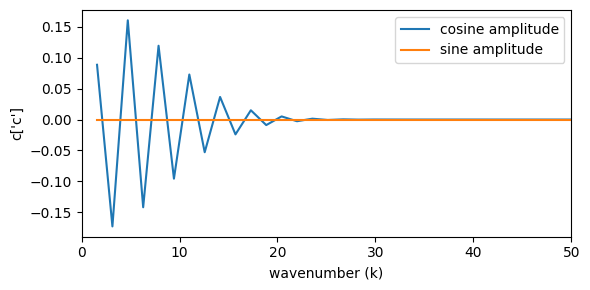

In [10]:
k = np.pi * np.arange(1, Nx/2+1) / (x_end - x_start) # Create an array of wavenumbers, k(i)=i*pi/Lx
plt.figure(figsize=(6, 3))
plt.plot(k, c['c'][0::2], label='cosine amplitude')
plt.plot(k, -c['c'][1::2], label='sine amplitude')
plt.xlabel('wavenumber (k)')
plt.ylabel("c['c']")
plt.xlim(0, 50)
plt.legend()
plt.tight_layout()

## 3. Problems and Solvers

Dedalus uses Problem and Solver classes to specify the problem and the methods that will be used to solve it. Here, we will set up the diffusion equation and solve it using the Crank-Nicolson timestepping method.

For more details on other problem types, see [Dedalus Tutorial 3](https://dedalus-project.readthedocs.io/en/latest/notebooks/dedalus_tutorial_2.html).

### Problems

Dedalus standardizes the formulation of all initial value problems by taking systems of symbolically specified equations and boundary conditions specified in the following generic form:

$$\mathcal{M} \cdot \partial_t \mathcal{X} + \mathcal{L} \cdot \mathcal{X} = \mathcal{F}(\mathcal{X}, t)$$

where $\mathcal{M}$ and $\mathcal{L}$ are matrices of linear differential operators, $\mathcal{X}$ is a state vector of the unknown fields, $\mathcal{F}$ is a vector of general nonlinear expressions.

The left-hand side (LHS) of the equations must be first-order in temporal derivatives and linear in the problem variables.
The right-hand side (RHS) of the equations may contain nonlinear and time-dependent terms, but no temporal derivatives.

When using a mixed implicit/explicit timestepping scheme, Dedalus will apply the implicit method to the $\mathcal{L}\cdot \mathcal{X}$ term and the explicit method to the $\mathcal{F}(\mathcal{X}, t)$ term.

To create a problem object, we provide a list of the variables to be solved for. In this case, this is just `c`.

Equations can then be entered as pairs of operator expressions like `(LHS, RHS)` or as strings like `"LHS = RHS"`.

Here, let's set up the diffusion equation:

$$\partial_t c - \kappa \partial_x^2 c = 0$$

Note that we put the term with the second derivative on the left hand side of the equation so that it will be time-stepped implicitly.

In [11]:
# Parameters
kappa = 0.001

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord) # Define the derivative (d/dx) operator

# Specify the problem
problem = dedalus.IVP([c], namespace=locals()) # Initial value problem, including all local variables
problem.add_equation("dt(c) - kappa*dx(dx(c)) = 0"); # Write out the equation to be solved


### 3.2 Solvers

Now, we need to specify the solver.  For IVPs, we specify a timestepping method when building the solver. Below we select the `CNAB1` timestepper which uses Crank-Nicolson for the $\mathcal{L}\cdot \mathcal{X}$ term and the explicit first order Adams-Bashforth method for the right hand side term (but in this case the RHS is zero).

In [12]:
timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+01/s


2024-12-27 05:53:03,892 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+01/s


Next, we need to specify a condition for the simulation to end. This can be a set number of iterations (set using `solver.stop_iteration`), a stopping time in simulation time units (set using `solver.stop_sim_time`, or a maximum wall clock time in seconds (set using `solver.stop_wall_time`).



In [13]:

solver.stop_sim_time = 10 # Stop at 10 simulation time units

IVPs are iterated using the `solver.step` method with a provided timestep.
The logic controlling the main-loop of a Dedalus IVP simulation occurs explicitly in the simulation script.
The `solver.proceed` property will change from `True` to `False` once any of the specified stopping criteria have been met.
Let's timestep our problem until the halting condition is reached, copying the grid values of `u` every few iterations.
This should take just a few seconds to run.

In [14]:
# Main loop
timestep = 0.1
c.change_scales(1)
c_save = [np.copy(c['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0: # Every 500 timesteps, print a message to the screen with the progress
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    # save the values of c and t
    c.change_scales(1)
    c_save.append(np.copy(c['g']))
    t_save.append(solver.sim_time)

INFO:solvers:Simulation stop time reached.


2024-12-27 05:53:06,820 solvers 0/1 INFO :: Simulation stop time reached.


Now we can make a space-time plot of the solution:

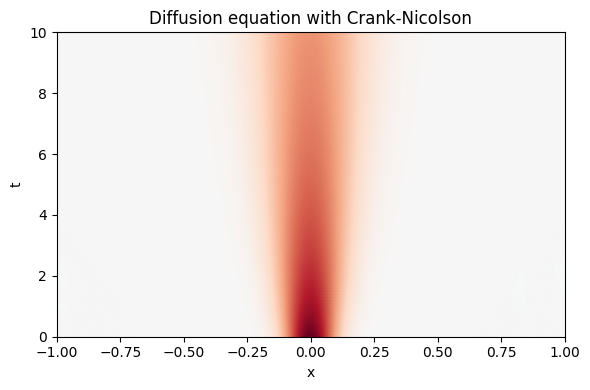

In [15]:
# Plot
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t_save), np.array(c_save), cmap='RdBu_r', shading='gouraud', rasterized=True, clim=(-1, 1))
plt.xlim(x_start, x_end)
plt.ylim(0, solver.stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title(f'Diffusion equation with Crank-Nicolson')
plt.tight_layout()

## 4. Forced diffusion equation

Dedalus is extremely flexible, which will make it very useful throughout the QCES computational projects. For example, it is relatively straightforward to change the equation that we are solving.

In order to introduce functions into the equations that Dedalus solves, we need to define a new operator.  For example, the following code defines the function $sin(x)$ on our grid:

In [16]:
# Create an operator that applies a function to the variable on a grid
sin_x = dist.Field(bases=x_basis)
sin_x['g'] = np.sin(x)

The code below uses Dedlaus to solve the forced diffusion equation:

$$\partial_t c - \kappa \partial_x^2 c = cos(\pi x / L_x)$$

with the same Gaussian initial condition as before. This example also shows what a complete Dedalus script looks like.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+01/s


2024-12-27 05:53:11,732 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+01/s


INFO:solvers:Simulation stop time reached.


2024-12-27 05:53:11,770 solvers 0/1 INFO :: Simulation stop time reached.


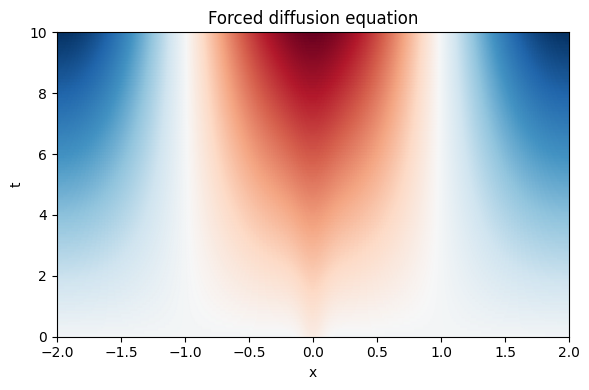

In [17]:
# Load the required packages (these were loaded above and are inluded here for completeness)
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# This script solves the forced diffusion equation with Dedlaus

# Set some parameters for the problem to be solved
Nx = 1024 # The number of gridpoints. Note that Fourier transforms are more efficient if this is a power of 2
Lx = 2; # The domain size in x.  This should be large enough so that the solution goes to zero at the endpoints.
x_start=-Lx; x_end=Lx # The starting and ending bounds on x
kappa = 0.001 # set the diffusivity

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))
x = dist.local_grid(x_basis)

# Set initial conditions
c = dist.Field(name='c', bases=x_basis)
w = 0.1 # Set the width of the initial Gaussian
c.change_scales(1) # Set values on regular grid
c['g'] = np.exp(-x**2/w**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord) # Define the derivative (d/dx) operator

# Create an operator that applies a function to the variable on a grid
f_x = dist.Field(bases=x_basis)
f_x['g'] = np.cos(np.pi * x / Lx)

# Specify the problem
problem = dedalus.IVP([c], namespace=locals()) # Initial value problem, including all local variables
problem.add_equation("dt(c) - kappa * dx(dx(c)) = f_x"); # Write out the equation to be solved

timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)

solver.stop_sim_time = 10 # Stop at 10 simulation time units

# Main loop
timestep = 0.1
c.change_scales(1)
c_save = [np.copy(c['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0: # Every 500 timesteps, print a message to the screen with the progress
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    c.change_scales(1)
    c_save.append(np.copy(c['g']))
    t_save.append(solver.sim_time)

# Plot
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t_save), np.array(c_save), cmap='RdBu_r', shading='gouraud', rasterized=True)#, clim=(-1, 1))
plt.xlim(x_start, x_end)
plt.ylim(0, solver.stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Forced diffusion equation')
plt.tight_layout()

## 5. Student investigation
<a id='student_investigation'></a>

### 5.1 Steady-state solution to the forced diffusion equation

For the forced diffusion equation described in section 4, using dimensional analysis, estimate the time needed to reach a steady-state solution. Test this scaling, and discuss your results below. Run the code above for a sufficient time to achieve a steady-state solution. Plot $c$ at the end of this simulation, and compare it with the exact steady-state solution to the forced diffusion equation.

Students should comment on the timescale needed to transition from the initial condition to the forced solution, and comment on the diffusive and forcing timescales.

### Dimensional Analysis

We consider the forced diffusion equation:

$$
\partial_t c - \kappa \partial_x^2 c = \cos\left(\frac{\pi x}{L_x}\right).
$$

At steady-state, we have:

$$
\partial_t c = 0 \implies \kappa \partial_x^2 c = -\cos\left(\frac{\pi x}{L_x}\right).
$$

The characteristic timescale for the diffusion process is determined by the diffusivity and the size of the spatial domain:

$$
\tau = \frac{L_x^2}{\kappa}.
$$

Substituting the parameters $ L_x = 2 $ and $ \kappa = 0.001$, we get:

$$
\tau = \frac{2^2}{0.001} = 4000.
$$

Thus, we expect the solution to reach a steady state on the timescale $ t \sim \tau = 4000 $.


### Exact Steady-State Solution

#### Particular Solution $c(x, t)$

From the steady-state equation:

$$
\kappa \partial_x^2 c = -\cos\left(\frac{\pi x}{Lx}\right),
$$

integrate twice with respect to $x$:

$$
c(x) = \frac{1}{\kappa \left(\frac{\pi}{Lx}\right)^2} \cos\left(\frac{\pi x}{Lx}\right) + Ax + B.
$$

The boundary conditions or symmetry properties of $c$ will determine $A$ and $B$.

For simplicity, assume periodic or zero-flux boundary conditions. This implies $A = 0$, and we get:

$$
c(x) = \frac{{L_x}^2}{\kappa \pi^2} \cos\left(\frac{\pi x}{L_x}\right).
$$

#### Homogeneous Solution $c_h(x, t)$

The homogeneous part of the solution takes the standard form of the diffusion process:

$$
c_h(x, t) = \sum_{n} B_n e^{-\kappa k_n^2 t} \cos(k_n x),
$$

where $ k_n = \frac{n\pi}{L_x} $ are the Fourier modes, and $ B_n $ are coefficients determined by the initial condition.


#### Complete Solution

The complete solution is given by:

$$
c(x, t) = \sum_{n} B_n e^{-\kappa k_n^2 t} \cos(k_n x) + \frac{L_x^2}{\kappa \pi^2} \cos\left(\frac{\pi x}{L_x}\right).
$$

- The **first term** represents the homogeneous solution, which decays over time.
- The **second term** is the steady-state solution, driven by the forcing term.



#### Steady-State Solution (Long-Term Behavior)

As $ t \to \infty $, the homogeneous solution $ c_h(x, t) $ decays to zero, and the solution approaches the steady state:

$$
c_{\text{steady}}(x) = \frac{L_x^2}{\kappa \pi^2} \cos\left(\frac{\pi x}{L_x}\right).
$$

Therefore, the exact solution is $c(0) = \frac{L_x^2}{\kappa \pi^2} = \frac{2^2}{0.001\times \pi^2} = 405.28$


## Timescale for Transition to Forced Solution

The transition from the initial condition to the forced solution involves two competing processes:

1. **Diffusion**: The initial Gaussian profile spreads due to diffusion, governed by the diffusivity $\kappa$.
2. **Forcing**: The external forcing term, $\cos\left(\frac{\pi x}{L_x}\right)$, drives the system towards a steady-state profile.

The system requires a time approximately equal to the diffusive timescale ($\sim 4000$) to fully transition to the steady-state solution. This is consistent with the dimensional analysis.


2024-12-27 05:58:23,810 dedalus 0/1 WARNING :: Threading has not been disabled. This may massively degrade Dedalus performance.


2024-12-27 05:58:23,822 dedalus 0/1 WARNING :: We strongly suggest setting the "OMP_NUM_THREADS" environment variable to "1".


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


2024-12-27 05:58:24,339 numexpr.utils 0/1 INFO :: NumExpr defaulting to 2 threads.


DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: dt(c) + -1*0.001*dx(dx(c))
DEBUG:problems:  RHS: <Field 133793655932240>
DEBUG:problems:  condition: True
DEBUG:problems:  M: c
DEBUG:problems:  L: -1*0.001*dx(dx(c))
DEBUG:problems:  F: <Field 133793655932240>
DEBUG:solvers:Beginning IVP instantiation
INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-12-27 05:58:27,587 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


DEBUG:solvers:Finished IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (1024,), 0)
INFO:__main__:Iteration=500, Time=5.000000e+01, dt=1.000000e-01


2024-12-27 05:58:28,131 __main__ 0/1 INFO :: Iteration=500, Time=5.000000e+01, dt=1.000000e-01


INFO:__main__:Iteration=1000, Time=1.000000e+02, dt=1.000000e-01


2024-12-27 05:58:28,320 __main__ 0/1 INFO :: Iteration=1000, Time=1.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=1500, Time=1.500000e+02, dt=1.000000e-01


2024-12-27 05:58:28,497 __main__ 0/1 INFO :: Iteration=1500, Time=1.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=2000, Time=2.000000e+02, dt=1.000000e-01


2024-12-27 05:58:28,683 __main__ 0/1 INFO :: Iteration=2000, Time=2.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=2500, Time=2.500000e+02, dt=1.000000e-01


2024-12-27 05:58:28,865 __main__ 0/1 INFO :: Iteration=2500, Time=2.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=3000, Time=3.000000e+02, dt=1.000000e-01


2024-12-27 05:58:29,063 __main__ 0/1 INFO :: Iteration=3000, Time=3.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=3500, Time=3.500000e+02, dt=1.000000e-01


2024-12-27 05:58:29,246 __main__ 0/1 INFO :: Iteration=3500, Time=3.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=4000, Time=4.000000e+02, dt=1.000000e-01


2024-12-27 05:58:29,409 __main__ 0/1 INFO :: Iteration=4000, Time=4.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=4500, Time=4.500000e+02, dt=1.000000e-01


2024-12-27 05:58:29,575 __main__ 0/1 INFO :: Iteration=4500, Time=4.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=5000, Time=5.000000e+02, dt=1.000000e-01


2024-12-27 05:58:29,734 __main__ 0/1 INFO :: Iteration=5000, Time=5.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=5500, Time=5.500000e+02, dt=1.000000e-01


2024-12-27 05:58:29,920 __main__ 0/1 INFO :: Iteration=5500, Time=5.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=6000, Time=6.000000e+02, dt=1.000000e-01


2024-12-27 05:58:30,116 __main__ 0/1 INFO :: Iteration=6000, Time=6.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=6500, Time=6.500000e+02, dt=1.000000e-01


2024-12-27 05:58:30,274 __main__ 0/1 INFO :: Iteration=6500, Time=6.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=7000, Time=7.000000e+02, dt=1.000000e-01


2024-12-27 05:58:30,438 __main__ 0/1 INFO :: Iteration=7000, Time=7.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=7500, Time=7.500000e+02, dt=1.000000e-01


2024-12-27 05:58:30,606 __main__ 0/1 INFO :: Iteration=7500, Time=7.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=8000, Time=8.000000e+02, dt=1.000000e-01


2024-12-27 05:58:30,823 __main__ 0/1 INFO :: Iteration=8000, Time=8.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=8500, Time=8.500000e+02, dt=1.000000e-01


2024-12-27 05:58:31,122 __main__ 0/1 INFO :: Iteration=8500, Time=8.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=9000, Time=9.000000e+02, dt=1.000000e-01


2024-12-27 05:58:31,379 __main__ 0/1 INFO :: Iteration=9000, Time=9.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=9500, Time=9.500000e+02, dt=1.000000e-01


2024-12-27 05:58:31,656 __main__ 0/1 INFO :: Iteration=9500, Time=9.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=10000, Time=1.000000e+03, dt=1.000000e-01


2024-12-27 05:58:31,845 __main__ 0/1 INFO :: Iteration=10000, Time=1.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=10500, Time=1.050000e+03, dt=1.000000e-01


2024-12-27 05:58:32,012 __main__ 0/1 INFO :: Iteration=10500, Time=1.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=11000, Time=1.100000e+03, dt=1.000000e-01


2024-12-27 05:58:32,202 __main__ 0/1 INFO :: Iteration=11000, Time=1.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=11500, Time=1.150000e+03, dt=1.000000e-01


2024-12-27 05:58:32,369 __main__ 0/1 INFO :: Iteration=11500, Time=1.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=12000, Time=1.200000e+03, dt=1.000000e-01


2024-12-27 05:58:32,537 __main__ 0/1 INFO :: Iteration=12000, Time=1.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=12500, Time=1.250000e+03, dt=1.000000e-01


2024-12-27 05:58:32,696 __main__ 0/1 INFO :: Iteration=12500, Time=1.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=13000, Time=1.300000e+03, dt=1.000000e-01


2024-12-27 05:58:32,866 __main__ 0/1 INFO :: Iteration=13000, Time=1.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=13500, Time=1.350000e+03, dt=1.000000e-01


2024-12-27 05:58:33,044 __main__ 0/1 INFO :: Iteration=13500, Time=1.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=14000, Time=1.400000e+03, dt=1.000000e-01


2024-12-27 05:58:33,238 __main__ 0/1 INFO :: Iteration=14000, Time=1.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=14500, Time=1.450000e+03, dt=1.000000e-01


2024-12-27 05:58:33,406 __main__ 0/1 INFO :: Iteration=14500, Time=1.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=15000, Time=1.500000e+03, dt=1.000000e-01


2024-12-27 05:58:33,571 __main__ 0/1 INFO :: Iteration=15000, Time=1.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=15500, Time=1.550000e+03, dt=1.000000e-01


2024-12-27 05:58:33,735 __main__ 0/1 INFO :: Iteration=15500, Time=1.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=16000, Time=1.600000e+03, dt=1.000000e-01


2024-12-27 05:58:33,899 __main__ 0/1 INFO :: Iteration=16000, Time=1.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=16500, Time=1.650000e+03, dt=1.000000e-01


2024-12-27 05:58:34,086 __main__ 0/1 INFO :: Iteration=16500, Time=1.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=17000, Time=1.700000e+03, dt=1.000000e-01


2024-12-27 05:58:34,262 __main__ 0/1 INFO :: Iteration=17000, Time=1.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=17500, Time=1.750000e+03, dt=1.000000e-01


2024-12-27 05:58:34,430 __main__ 0/1 INFO :: Iteration=17500, Time=1.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=18000, Time=1.800000e+03, dt=1.000000e-01


2024-12-27 05:58:34,603 __main__ 0/1 INFO :: Iteration=18000, Time=1.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=18500, Time=1.850000e+03, dt=1.000000e-01


2024-12-27 05:58:34,761 __main__ 0/1 INFO :: Iteration=18500, Time=1.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=19000, Time=1.900000e+03, dt=1.000000e-01


2024-12-27 05:58:35,029 __main__ 0/1 INFO :: Iteration=19000, Time=1.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=19500, Time=1.950000e+03, dt=1.000000e-01


2024-12-27 05:58:35,306 __main__ 0/1 INFO :: Iteration=19500, Time=1.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=20000, Time=2.000000e+03, dt=1.000000e-01


2024-12-27 05:58:35,586 __main__ 0/1 INFO :: Iteration=20000, Time=2.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=20500, Time=2.050000e+03, dt=1.000000e-01


2024-12-27 05:58:35,840 __main__ 0/1 INFO :: Iteration=20500, Time=2.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=21000, Time=2.100000e+03, dt=1.000000e-01


2024-12-27 05:58:36,097 __main__ 0/1 INFO :: Iteration=21000, Time=2.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=21500, Time=2.150000e+03, dt=1.000000e-01


2024-12-27 05:58:36,351 __main__ 0/1 INFO :: Iteration=21500, Time=2.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=22000, Time=2.200000e+03, dt=1.000000e-01


2024-12-27 05:58:36,582 __main__ 0/1 INFO :: Iteration=22000, Time=2.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=22500, Time=2.250000e+03, dt=1.000000e-01


2024-12-27 05:58:36,828 __main__ 0/1 INFO :: Iteration=22500, Time=2.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=23000, Time=2.300000e+03, dt=1.000000e-01


2024-12-27 05:58:37,117 __main__ 0/1 INFO :: Iteration=23000, Time=2.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=23500, Time=2.350000e+03, dt=1.000000e-01


2024-12-27 05:58:37,389 __main__ 0/1 INFO :: Iteration=23500, Time=2.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=24000, Time=2.400000e+03, dt=1.000000e-01


2024-12-27 05:58:37,669 __main__ 0/1 INFO :: Iteration=24000, Time=2.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=24500, Time=2.450000e+03, dt=1.000000e-01


2024-12-27 05:58:37,930 __main__ 0/1 INFO :: Iteration=24500, Time=2.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=25000, Time=2.500000e+03, dt=1.000000e-01


2024-12-27 05:58:38,231 __main__ 0/1 INFO :: Iteration=25000, Time=2.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=25500, Time=2.550000e+03, dt=1.000000e-01


2024-12-27 05:58:38,560 __main__ 0/1 INFO :: Iteration=25500, Time=2.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=26000, Time=2.600000e+03, dt=1.000000e-01


2024-12-27 05:58:38,756 __main__ 0/1 INFO :: Iteration=26000, Time=2.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=26500, Time=2.650000e+03, dt=1.000000e-01


2024-12-27 05:58:38,928 __main__ 0/1 INFO :: Iteration=26500, Time=2.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=27000, Time=2.700000e+03, dt=1.000000e-01


2024-12-27 05:58:39,116 __main__ 0/1 INFO :: Iteration=27000, Time=2.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=27500, Time=2.750000e+03, dt=1.000000e-01


2024-12-27 05:58:39,283 __main__ 0/1 INFO :: Iteration=27500, Time=2.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=28000, Time=2.800000e+03, dt=1.000000e-01


2024-12-27 05:58:39,447 __main__ 0/1 INFO :: Iteration=28000, Time=2.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=28500, Time=2.850000e+03, dt=1.000000e-01


2024-12-27 05:58:39,628 __main__ 0/1 INFO :: Iteration=28500, Time=2.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=29000, Time=2.900000e+03, dt=1.000000e-01


2024-12-27 05:58:39,794 __main__ 0/1 INFO :: Iteration=29000, Time=2.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=29500, Time=2.950000e+03, dt=1.000000e-01


2024-12-27 05:58:39,960 __main__ 0/1 INFO :: Iteration=29500, Time=2.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=30000, Time=3.000000e+03, dt=1.000000e-01


2024-12-27 05:58:40,141 __main__ 0/1 INFO :: Iteration=30000, Time=3.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=30500, Time=3.050000e+03, dt=1.000000e-01


2024-12-27 05:58:40,309 __main__ 0/1 INFO :: Iteration=30500, Time=3.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=31000, Time=3.100000e+03, dt=1.000000e-01


2024-12-27 05:58:40,471 __main__ 0/1 INFO :: Iteration=31000, Time=3.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=31500, Time=3.150000e+03, dt=1.000000e-01


2024-12-27 05:58:40,655 __main__ 0/1 INFO :: Iteration=31500, Time=3.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=32000, Time=3.200000e+03, dt=1.000000e-01


2024-12-27 05:58:40,818 __main__ 0/1 INFO :: Iteration=32000, Time=3.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=32500, Time=3.250000e+03, dt=1.000000e-01


2024-12-27 05:58:40,986 __main__ 0/1 INFO :: Iteration=32500, Time=3.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=33000, Time=3.300000e+03, dt=1.000000e-01


2024-12-27 05:58:41,169 __main__ 0/1 INFO :: Iteration=33000, Time=3.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=33500, Time=3.350000e+03, dt=1.000000e-01


2024-12-27 05:58:41,334 __main__ 0/1 INFO :: Iteration=33500, Time=3.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=34000, Time=3.400000e+03, dt=1.000000e-01


2024-12-27 05:58:41,496 __main__ 0/1 INFO :: Iteration=34000, Time=3.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=34500, Time=3.450000e+03, dt=1.000000e-01


2024-12-27 05:58:41,681 __main__ 0/1 INFO :: Iteration=34500, Time=3.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=35000, Time=3.500000e+03, dt=1.000000e-01


2024-12-27 05:58:41,846 __main__ 0/1 INFO :: Iteration=35000, Time=3.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=35500, Time=3.550000e+03, dt=1.000000e-01


2024-12-27 05:58:42,024 __main__ 0/1 INFO :: Iteration=35500, Time=3.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=36000, Time=3.600000e+03, dt=1.000000e-01


2024-12-27 05:58:42,203 __main__ 0/1 INFO :: Iteration=36000, Time=3.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=36500, Time=3.650000e+03, dt=1.000000e-01


2024-12-27 05:58:42,370 __main__ 0/1 INFO :: Iteration=36500, Time=3.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=37000, Time=3.700000e+03, dt=1.000000e-01


2024-12-27 05:58:42,535 __main__ 0/1 INFO :: Iteration=37000, Time=3.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=37500, Time=3.750000e+03, dt=1.000000e-01


2024-12-27 05:58:42,713 __main__ 0/1 INFO :: Iteration=37500, Time=3.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=38000, Time=3.800000e+03, dt=1.000000e-01


2024-12-27 05:58:42,880 __main__ 0/1 INFO :: Iteration=38000, Time=3.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=38500, Time=3.850000e+03, dt=1.000000e-01


2024-12-27 05:58:43,060 __main__ 0/1 INFO :: Iteration=38500, Time=3.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=39000, Time=3.900000e+03, dt=1.000000e-01


2024-12-27 05:58:43,229 __main__ 0/1 INFO :: Iteration=39000, Time=3.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=39500, Time=3.950000e+03, dt=1.000000e-01


2024-12-27 05:58:43,389 __main__ 0/1 INFO :: Iteration=39500, Time=3.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=40000, Time=4.000000e+03, dt=1.000000e-01


2024-12-27 05:58:43,553 __main__ 0/1 INFO :: Iteration=40000, Time=4.000000e+03, dt=1.000000e-01


INFO:solvers:Simulation stop time reached.


2024-12-27 05:58:43,560 solvers 0/1 INFO :: Simulation stop time reached.


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/lo

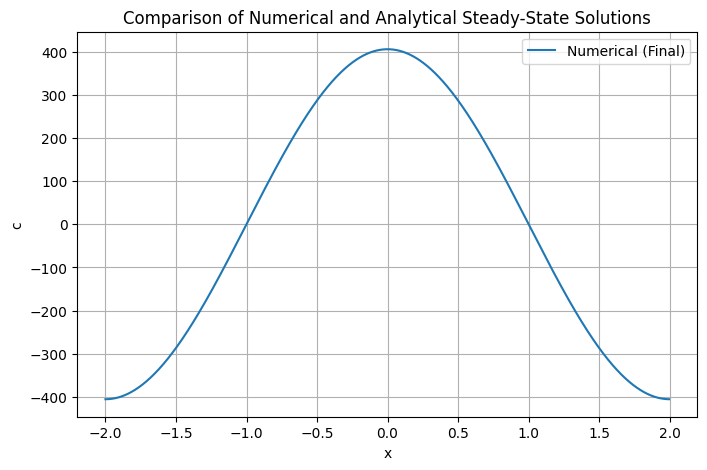

In [1]:
# Load the required packages (these were loaded above and are inluded here for completeness)
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# This script solves the forced diffusion equation with Dedlaus

# Set some parameters for the problem to be solved
Nx = 1024 # The number of gridpoints. Note that Fourier transforms are more efficient if this is a power of 2
Lx = 2; # The domain size in x.  This should be large enough so that the solution goes to zero at the endpoints.
x_start=-Lx; x_end=Lx # The starting and ending bounds on x
kappa = 0.001 # set the diffusivity

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))
x = dist.local_grid(x_basis)

# Set initial conditions
c = dist.Field(name='c', bases=x_basis)
w = 0.1 # Set the width of the initial Gaussian
c.change_scales(1) # Set values on regular grid
c['g'] = np.exp(-x**2/w**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord) # Define the derivative (d/dx) operator

# Create an operator that applies a function to the variable on a grid
f_x = dist.Field(bases=x_basis)
f_x['g'] = np.cos(np.pi * x / Lx)

# Specify the problem
problem = dedalus.IVP([c], namespace=locals()) # Initial value problem, including all local variables
problem.add_equation("dt(c) - kappa * dx(dx(c)) = f_x"); # Write out the equation to be solved

timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)

solver.stop_sim_time = 4000 # Stop at 10 simulation time units

# Main loop
timestep = 0.1
c.change_scales(1)
c_save = [np.copy(c['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0: # Every 500 timesteps, print a message to the screen with the progress
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    c.change_scales(1)
    c_save.append(np.copy(c['g']))
    t_save.append(solver.sim_time)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x.ravel(), c['g'], label="Numerical (Final)")
#plt.plot(x.ravel(), c_analytical, label="Analytical Steady-State", linestyle='--')
plt.xlabel('x')
plt.ylabel('c')
plt.title('Comparison of Numerical and Analytical Steady-State Solutions')
plt.legend()
plt.grid()
plt.show()

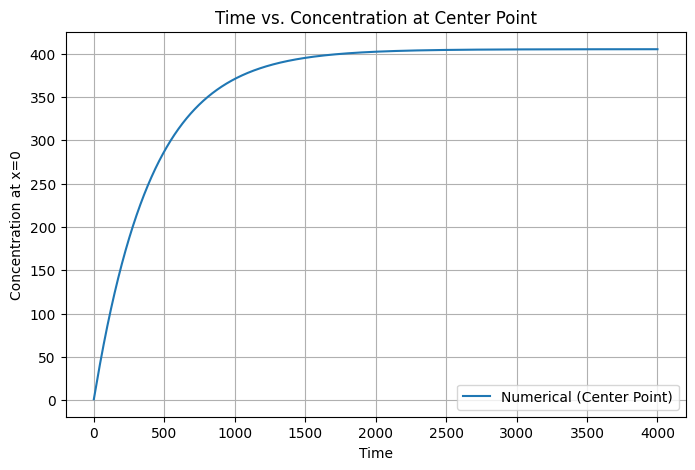

In [3]:
# Find the index of the spatial point closest to x=0
center_index = np.argmin(np.abs(x.ravel()))  # Index of the spatial point closest to x=0

# Extract the concentration at the center point over time
c_center_over_time = [c_snapshot[center_index] for c_snapshot in c_save]

# Plot time vs. concentration at the center
plt.figure(figsize=(8, 5))
plt.plot(t_save, c_center_over_time, label="Numerical (Center Point)")
plt.xlabel('Time')
plt.ylabel('Concentration at x=0')
plt.title('Time vs. Concentration at Center Point')
plt.legend()
plt.grid()
plt.show()


Based on the plot, the system appears to reach the steady state at around $ 4000 \, \mathrm{s} $. The simulated concentration at the center point ($ x = 0 $) closely matches the value predicted by the theoretical steady-state solution, demonstrating good agreement between the numerical and theoretical results.

### 5.2 Variable difusivity

In some applications of the diffusion equation, the diffusivity varies in space. This happens, for example, in the movement of pollution in groundwater flowing through soil of variable porosity, or the mixing of tracers due to turbulence in the ocean (which we will explore in detail in Project 2).

In the code cell below, write a Dedalus script that solves the following equation:

$$\partial_t c - \partial_x(\kappa (x) \partial_x c) = 0$$

where

$$\kappa(x)=\kappa_0(0.1 + tanh(x/0.1)+1)/2$$

and $\kappa_0=0.001$. It is fine to start by copying the code in the previous cell and changing the problem equation appropriately.

DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: dt(c) + -1*dx(kappa*dx(c))
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: c
DEBUG:problems:  L: -1*dx(kappa*dx(c))
DEBUG:problems:  F: <Field 133792579537168>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (1024,), 0)
INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


2024-12-27 06:23:12,589 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:solvers:Simulation stop time reached.


2024-12-27 06:23:13,002 solvers 0/1 INFO :: Simulation stop time reached.


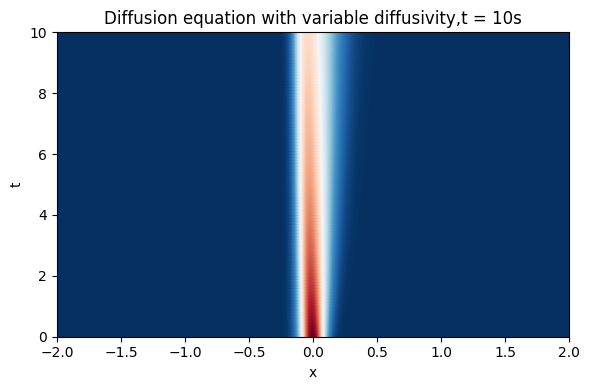

In [12]:
# Parameters for the problem
Nx = 1024  # Number of grid points
Lx = 2  # Domain size in x
x_start = -Lx  # Starting bound of x
x_end = Lx  # Ending bound of x
kappa_0 = 0.001  # Base diffusivity

# Create x-coordinate, basis, and distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64)
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))
x = dist.local_grid(x_basis)

# Initial condition
c = dist.Field(name='c', bases=x_basis)
w = 0.1  # Width of the initial Gaussian
c.change_scales(1)
c['g'] = np.exp(-x**2 / w**2)  # Gaussian initial condition

# Define the spatially varying diffusivity
kappa = dist.Field(name='kappa', bases=x_basis)
kappa['g'] = kappa_0 * (0.1 + np.tanh(x / 0.1) + 1) / 2

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord)  # Derivative operator

# Specify the problem
problem = dedalus.IVP([c], namespace=locals())
problem.add_equation("dt(c) - dx(kappa * dx(c)) = 0")  # PDE to solve

# Time stepper and solver
timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)

solver.stop_sim_time = 10  # Stop at 10 simulation time units

# Main loop
timestep = 0.1
c.change_scales(1)
c_save = [np.copy(c['g'])]  # Save initial condition
t_save = [solver.sim_time]

while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0:
        logger.info(f"Iteration={solver.iteration}, Time={solver.sim_time:.4e}, dt={timestep:.4e}")
    c.change_scales(1)
    c_save.append(np.copy(c['g']))
    t_save.append(solver.sim_time)

# Convert to arrays for plotting
t_save = np.array(t_save)
c_save = np.array(c_save)

# Plotting
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), t_save, c_save, cmap='RdBu_r', shading='gouraud', rasterized=True)
plt.xlim(x_start, x_end)
plt.ylim(0, solver.stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Diffusion equation with variable diffusivity,t = 10s')
plt.tight_layout()
plt.show()


DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: dt(c) + -1*dx(kappa*dx(c))
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: c
DEBUG:problems:  L: -1*dx(kappa*dx(c))
DEBUG:problems:  F: <Field 133792631664320>
DEBUG:solvers:Beginning IVP instantiation
INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 4s, Remaining: 0s, Rate: 2.6e-01/s


2024-12-27 06:23:19,456 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 4s, Remaining: 0s, Rate: 2.6e-01/s


DEBUG:solvers:Finished IVP instantiation
INFO:solvers:Simulation stop time reached.


2024-12-27 06:23:20,034 solvers 0/1 INFO :: Simulation stop time reached.


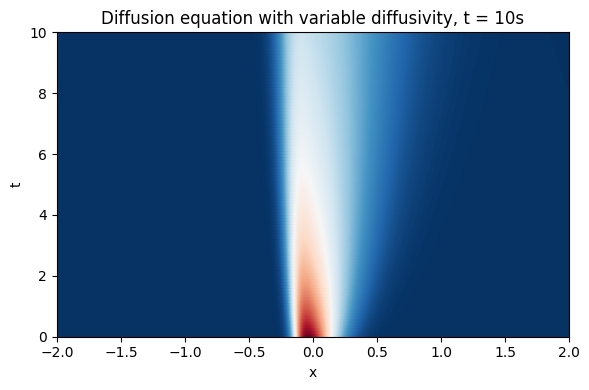

In [13]:
kappa_0 = 0.01  # Base diffusivity

# Define the spatially varying diffusivity
kappa = dist.Field(name='kappa', bases=x_basis)
kappa['g'] = kappa_0 * (0.1 + np.tanh(x / 0.1) + 1) / 2

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord)  # Derivative operator

# Specify the problem
problem = dedalus.IVP([c], namespace=locals())
problem.add_equation("dt(c) - dx(kappa * dx(c)) = 0")  # PDE to solve

# Time stepper and solver
timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)

solver.stop_sim_time = 10  # Stop at 10 simulation time units

# Main loop
timestep = 0.1
c.change_scales(1)
c_save = [np.copy(c['g'])]  # Save initial condition
t_save = [solver.sim_time]

while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0:
        logger.info(f"Iteration={solver.iteration}, Time={solver.sim_time:.4e}, dt={timestep:.4e}")
    c.change_scales(1)
    c_save.append(np.copy(c['g']))
    t_save.append(solver.sim_time)

# Convert to arrays for plotting
t_save = np.array(t_save)
c_save = np.array(c_save)

# Plotting
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), t_save, c_save, cmap='RdBu_r', shading='gouraud', rasterized=True)
plt.xlim(x_start, x_end)
plt.ylim(0, solver.stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Diffusion equation with variable diffusivity, t = 10s')
plt.tight_layout()
plt.show()


DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: dt(c) + -1*dx(kappa*dx(c))
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: c
DEBUG:problems:  L: -1*dx(kappa*dx(c))
DEBUG:problems:  F: <Field 133792309987216>
DEBUG:solvers:Beginning IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (1024,), 0)
INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


2024-12-27 06:23:25,422 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


DEBUG:solvers:Finished IVP instantiation
INFO:__main__:Iteration=500, Time=5.0000e+01, dt=1.0000e-01


2024-12-27 06:23:26,925 __main__ 0/1 INFO :: Iteration=500, Time=5.0000e+01, dt=1.0000e-01


INFO:__main__:Iteration=1000, Time=1.0000e+02, dt=1.0000e-01


2024-12-27 06:23:28,264 __main__ 0/1 INFO :: Iteration=1000, Time=1.0000e+02, dt=1.0000e-01


INFO:solvers:Simulation stop time reached.


2024-12-27 06:23:28,272 solvers 0/1 INFO :: Simulation stop time reached.


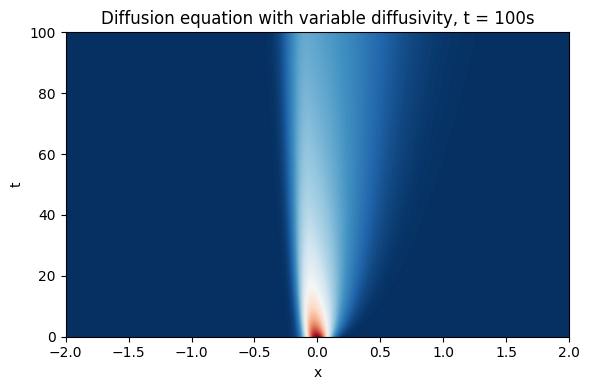

In [14]:
# Parameters for the problem
Nx = 1024  # Number of grid points
Lx = 2  # Domain size in x
x_start = -Lx  # Starting bound of x
x_end = Lx  # Ending bound of x
kappa_0 = 0.001  # Base diffusivity

# Create x-coordinate, basis, and distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64)
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))
x = dist.local_grid(x_basis)

# Initial condition
c = dist.Field(name='c', bases=x_basis)
w = 0.1  # Width of the initial Gaussian
c.change_scales(1)
c['g'] = np.exp(-x**2 / w**2)  # Gaussian initial condition

# Define the spatially varying diffusivity
kappa = dist.Field(name='kappa', bases=x_basis)
kappa['g'] = kappa_0 * (0.1 + np.tanh(x / 0.1) + 1) / 2

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord)  # Derivative operator

# Specify the problem
problem = dedalus.IVP([c], namespace=locals())
problem.add_equation("dt(c) - dx(kappa * dx(c)) = 0")  # PDE to solve

# Time stepper and solver
timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)

solver.stop_sim_time = 100  # Stop at 10 simulation time units

# Main loop
timestep = 0.1
c.change_scales(1)
c_save = [np.copy(c['g'])]  # Save initial condition
t_save = [solver.sim_time]

while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0:
        logger.info(f"Iteration={solver.iteration}, Time={solver.sim_time:.4e}, dt={timestep:.4e}")
    c.change_scales(1)
    c_save.append(np.copy(c['g']))
    t_save.append(solver.sim_time)

# Convert to arrays for plotting
t_save = np.array(t_save)
c_save = np.array(c_save)

# Plotting
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), t_save, c_save, cmap='RdBu_r', shading='gouraud', rasterized=True)
plt.xlim(x_start, x_end)
plt.ylim(0, solver.stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Diffusion equation with variable diffusivity, t = 100s')
plt.tight_layout()
plt.show()


### Comments on Observations
When $ \kappa_0 = 0.01 $, diffusion occurs significantly faster compared to $ \kappa_0 = 0.001 $.
This leads to the concentration profile becoming more uniform in a shorter amount of time.

This behavior is due to the higher diffusivity, which enhances the transport of material from regions of high concentration to regions of low concentration.

The diffusion process is asymmetric due to the spatially varying diffusivity $ \kappa(x) $:  
$$\kappa(x)=\kappa_0(0.1 + tanh(x/0.1)+1)/2$$

For $ x > 0 $, $ \kappa(x) $ is larger, $tanh(x/0.1)$ is positive and causing faster diffusion in this region, but for $x < 0 $, $tanh(x/0.1)$ is negative so this lead to the asymmetry pattern in the concentration profile.  
Conversely, for $ x < 0 $, $ \kappa(x) $ is smaller, leading to slower diffusion, but consist with the asymmetry pattern.

Higher $ \kappa_0 $ not only accelerates the diffusion rate but also reduces the concentration gradient more quickly throughout the domain.  
The asymmetry introduced by the diffusivity function $ \kappa(x) $ becomes more pronounced at higher values of $ \kappa_0 $.


## 6. Optional further investigations

* Try writing a Dedalus script to solve the 2D diffusion equation as an initial value problem.  You can look ahead to the the example at the end of the Project 2 notebook for some guidance (but remove the advection term). I would suggest using a Fourier/Fourier basis for this.

* Consider how you might go about discretizing a 2D diffusion equation using finite differences.  What form would the matrix M have?
